<a href="https://colab.research.google.com/github/nisheethrajesh/CANN/blob/main/CANN_Ogden_Roxburgh_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.8.2
Eager execution: True


In [ ]:
! git clone https://github.com/nisheethrajesh/CANN.git

fatal: destination path 'CANN' already exists and is not an empty directory.


In [ ]:
! ls CANN

MATLAB_Files			Mooney_Rivlin_PS_Train.csv
Mooney_Rivlin_EBT_Test.csv	Mooney_Rivlin_PS_Validate.csv
Mooney_Rivlin_EBT_Train.csv	Mooney_Rivlin_UT_Test.csv
Mooney_Rivlin_EBT_Validate.csv	Mooney_Rivlin_UT_Train.csv
Mooney_Rivlin_Lambda_10.csv	Mooney_Rivlin_UT_Validate.csv
Mooney_Rivlin_PS_Test.csv	Relative_Error_Files


#Function Definitions

In [ ]:
def deformation_grad(stretch, option=0):
  """
  Calculates the deformation gradient from the stretch for UT, EBT and PS loading.

  Parameters:
      stretch  : the stretch value.
      option   : specifies the loading method, 0-UT, 1-EBT, 2-PS 
  
  Returns:
      F        : the Deformation Gradient.

  """
  batch_size   = stretch.shape[0] 
  F            = tf.zeros([0, 3, 3], dtype=tf.float32)
  
  if option == 0:                 # Uniaxial Tension setting
    for i in range(batch_size):
      F_temp   = tf.Variable([[stretch[i], 0, 0],[0, 1/tf.sqrt(stretch[i]), 0], [0, 0, 1/tf.sqrt(stretch[i])]], dtype=tf.float32)
      J        = tf.pow(tf.linalg.det(F_temp), (-1/3))    # Jacobian
      F_temp   = tf.multiply(J, F_temp)
      F        = tf.Variable(tf.concat([F, [F_temp]], axis=0), dtype=tf.float32)
      
  
  elif option == 1:               # Equi-Biaxial Tension setting
    for i in range(batch_size):
      F_temp   = tf.Variable([[stretch[i], 0, 0],[0, stretch[i], 0], [0, 0, 1/tf.square(stretch[i])]], dtype=tf.float32)
      J        = tf.pow(tf.linalg.det(F_temp), (-1/3))   # Jacobian
      F_temp   = tf.multiply(J, F_temp)
      F        = tf.Variable(tf.concat([F, [F_temp]], axis=0), dtype=tf.float32)

  elif option == 2:               # Pure Shear setting
    for i in range(batch_size):
      F_temp   = tf.Variable([[stretch[i], 0, 0], [0, 1/stretch[i], 0], [0, 0, 1.]], dtype=tf.float32)
      J        = tf.pow(tf.linalg.det(F_temp), (-1/3))   # Jacobian
      F_temp   = tf.multiply(J, F_temp)
      F        = tf.Variable(tf.concat([F, [F_temp]], axis=0), dtype=tf.float32)

  return F

In [ ]:
def maximum_stretch(Stretch):
  """
  Calculates the Maximum Stretch history of the material under loading/unloading.

  Parameters:
      Stretch  :  the Stretches for loading/unloading

  Returns:
      mstretch :  the maximum stretch history

  """
  asize = Stretch.shape[0]
  mstretch = tf.Variable(tf.zeros(shape=[asize]), dtype=tf.float32)
  s_max = Stretch[0]
  for i in range(asize):
    if Stretch[i] >= s_max:
      s_max = Stretch[i]
      mstretch[i].assign(s_max)
    else:
      mstretch[i].assign(s_max)
  
  return mstretch 

In [ ]:
def remove_duplicates(mullins_data):
  """
  Used to remove the doubled Stress-Stretch values from subsequent reloading after unloading in the data. Also used to calculate the maximum stretch history.

  Parameters:
      mullins_data : pandas Dataframe containing Stress-Stretch values
  
  Returns:
      max_stretch  : the maximum stretch history of the material
      Stretch      : the stretch
      Stress_P11   : the P11 stress

  """
  max_stretch                  = maximum_stretch(tf.Variable(mullins_data["Stretch"], dtype=tf.float32))   # Calculate the maximum stretch history
  mullins_data["max_stretch"]  = max_stretch.numpy()                                                       # Add this max_stretch into another column in the Database
  mullins_data["Stretch"]      = np.round_(mullins_data["Stretch"], decimals=2)                            # Round off the Stretch values to 2 digits after the decimal
  mullins_data                 = mullins_data.drop_duplicates(subset=["Stretch", "max_stretch"])           # Remove duplicate values 

  # Return the values
  max_stretch = tf.Variable(mullins_data["max_stretch"], dtype=tf.float32) 
  Stretch     = tf.Variable(mullins_data["Stretch"], dtype=tf.float32)
  Stress_P11  = tf.Variable(mullins_data["Stress_P11"], dtype=tf.float32)

  return max_stretch, Stretch, Stress_P11

In [ ]:
def reference_values(F, max_stretch):
  """
  Calculates the Deformation gradient and the maximum stretch at the reference state.

  Parameters:
      mullins_data : pandas Dataframe containing Stress-Stretch values
  
  Returns:
      max_stretch  : the maximum stretch history of the material
      Stretch      : the stretch
      Stress_P11   : the P11 stress

  """
  batch_size = tf.shape(max_stretch)[0]
  F_ref      = tf.zeros([0, 3, 3], dtype=tf.float32)

  for i in range(batch_size):
    F_temp   = tf.eye(3, dtype=tf.float32)
    F_ref    = tf.concat([F_ref, [F_temp]], axis=0)
  
  max_stretch_ref = tf.ones(batch_size, dtype=tf.float32)

  return F_ref.numpy(), max_stretch_ref.numpy()

**Classes are used here for doing the calculations instead of functions as they were producing an error while calculating the gradients using GradientTape().** 

In [ ]:
# Calculates the right Cauchy Green Tensor from the Deformation Gradient
class right_CG_tensor(keras.layers.Layer):
  def __init__(self):
    super(right_CG_tensor, self).__init__()

  def call(self, inputs):
    return tf.matmul(inputs, inputs, transpose_a=True)

# Calculates the First strain invariant from the right Cauchy Green Tensor 
class first_invariant(keras.layers.Layer):
  def __init__(self):
    super(first_invariant, self).__init__()

  def call(self, inputs):
    return tf.reshape(tf.linalg.trace(inputs), (-1, 1))

# Calculates the Second strain invariant from the right Cauchy Green Tensor
class second_invariant(keras.layers.Layer):
  def __init__(self):
    super(second_invariant, self).__init__()
    self.const = tf.constant(0.5)

  def call(self, inputs):
    detC = tf.linalg.det(inputs)
    C_T = tf.linalg.inv(tf.transpose(inputs, perm=[0, 2, 1]))
    
    #II = tf.multiply(detC, tf.linalg.trace(C_T))
    II = self.const * tf.math.subtract(tf.square(tf.linalg.trace(inputs)), tf.linalg.trace(tf.matmul(inputs, inputs)))
    return tf.reshape(II, shape=(-1, 1))

In [ ]:
# Class for defining the training and test/validation methods for the CANN Model

class CANN_Model(keras.Model):

  def train_step(self, data): # Training step
    # Unpack the data. The structure is the input (deformation gradient and max_stretch variable) and output (stress labels)
    # This is passed to the .fit() function
    ((F, max_stretch), (F_ref, max_stretch_ref)), Stress = data

    # Computing the gradients
    with tf.GradientTape() as t2:                                   # For computing the gradient of loss
      with tf.GradientTape(watch_accessed_variables=False) as t1:   # For computing the gradient of strain energy function i.e the Stress
        t1.watch(F)
        Psi       = self((F, max_stretch), training=True)           # Forward Pass
        Psi_ref   = self((F_ref, max_stretch_ref), training=False)  # Forward Pass for the reference configuration
      
        Psi       = tf.math.subtract(Psi, Psi_ref)        

      # Compute the stress as a gradient of Strain energy function and Deformation gradient
      Stress_pred = t1.gradient(Psi, F)

      # Compute the loss value
      # (the loss function is configured in 'compile()')
      loss        = self.compiled_loss(Stress, Stress_pred[:, 0, 0])
    
    # Compute gradients
    gradients     = t2.gradient(loss, self.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(Stress, Stress_pred[:, 0, 0])
    
    # Return a dict mapping metric names to current value
    return {m.name : m.result() for m in self.metrics}

  def test_step(self, data): # Validation step
    # For validating the data in .fit() step
    ((F, max_stretch), (F_ref, max_stretch_ref)), Stress = data

    # Computing the gradients
    with tf.GradientTape() as t2:
      with tf.GradientTape(watch_accessed_variables=False) as t1:
        t1.watch(F)
        Psi       = self((F, max_stretch), training=False)                 # Forward Pass
        Psi_ref   = self((F_ref, max_stretch_ref), training=False)     # Forward Pass for the reference configuration
      
        Psi       = tf.math.subtract(Psi, Psi_ref)        

      # Compute the stress as a gradient of Strain energy function and Deformation gradient
      Stress_pred = t1.gradient(Psi, F)

      # Compute the loss value
      loss        = self.compiled_loss(Stress, Stress_pred[:, 0, 0])
    
    # Compute gradients
    gradients     = t2.gradient(loss, self.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(Stress, Stress_pred[:, 0, 0])
    
    # Return a dict mapping metric names to current value
    return {m.name : m.result() for m in self.metrics}

In [ ]:
def CANN():
  """
  Defines the layers of the CANN using the keras functional API and instantiates the CANN Model.

  Parameters:  

  Returns:
      model :  the CANN model

  """

  init         = keras.initializers.GlorotNormal()  # initializer for the kernel and bias

  #Layers of CANN

  Def_gradient = keras.layers.Input(shape=(3, 3), dtype=tf.float32, name="F")
  Max_stretch  = keras.layers.Input(shape=(1,), dtype=tf.float32, name="Max_stretch")
  rcg          = right_CG_tensor()
  C            = rcg(Def_gradient)
  
  F_I          = first_invariant()
  I            = F_I(C)
  concat1      = keras.layers.concatenate([I, Max_stretch])
  hidden0      = keras.layers.Dense(8, activation='softplus', kernel_initializer=init, bias_initializer=init)(concat1)
  hidden1      = keras.layers.Dense(8, activation='softplus', kernel_initializer=init, bias_initializer=init)(hidden0)

  S_I          = second_invariant()
  II           = S_I(C)
  concat2      = keras.layers.concatenate([II, Max_stretch])
  hidden2      = keras.layers.Dense(8, activation='softplus', kernel_initializer=init, bias_initializer=init)(concat2)
  hidden3      = keras.layers.Dense(8, activation='softplus', kernel_initializer=init, bias_initializer=init)(hidden2)

  concat       = keras.layers.concatenate([hidden1, hidden3])
  hidden4      = keras.layers.Dense(32, activation='softplus', kernel_initializer=init, bias_initializer=init)(concat)
  hidden5      = keras.layers.Dense(32, activation='softplus', kernel_initializer=init, bias_initializer=init)(hidden4)
  

  Psi          = keras.layers.Dense(1, activation="linear", kernel_initializer=init, use_bias=False, name="Psi")(hidden5)

  model        = CANN_Model(inputs=[Def_gradient, Max_stretch], outputs=Psi)
  
  return model

In [ ]:
def Stress_predicted(model, F, max_stretch):
  """
  Predicts the P11 Stress using the trained model and deformation gradient and max_stretch values.

  Parameters:
      model        : trained CANN model
      F            : deformation gradient values
      max_stretch  : maximum stretch values

  Returns:
      Stress_pred  : the predicted P11 stress

  """
  # Obtain the values of F and max_stretch at reference state
  F_ref, max_stretch_ref = reference_values(F, max_stretch)

  # Returns the P11 value predicted by the model
  max_stretch       = tf.reshape(max_stretch, (-1, 1))
  max_stretch_ref   = tf.reshape(max_stretch_ref, (-1, 1))
  
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(F)
    Psi_pred        = model((F, max_stretch), training=False)
    Psi_ref         = model((F_ref, max_stretch_ref), training=False)
    Psi_pred        = tf.math.subtract(Psi_pred, Psi_ref)
  
  Stress_pred       = tape.gradient(Psi_pred, F)
  
  return Stress_pred[:, 0, 0]

# Results

## **1. Ogden-Roxburgh material in Uniaxial Tension**


###**1.1 Training, validation and testing on different datasets:**

The material is tested in UT while applying three different maximum stretches. This data is then used for training and testing the CANN model : 

1. For testing   : 1 - 1.5 - 1 - 2 - 1 - 2.5 - 1 -... - 7
2. For validation: 1 - 1.75 - 1 - 2.5 - 1 - 3.25 - 1 -... -7
3. For testing: 1 - 2 - 1 - 3 - 1 -...- 7

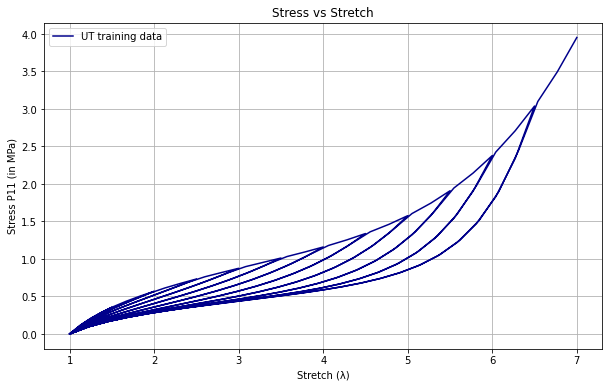

In [ ]:
# Importing the Training data
UT_train  = pd.read_csv("CANN/Mooney_Rivlin_UT_Train.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_train["Stretch"], UT_train["Stress_P11"], color='darkblue', label="UT training data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch')
_ = plt.grid(visible=True)
_ = plt.legend()

In [ ]:
# Removing the duplicates in the data and getting the maximum stretches as the variable "max_stretch"
max_stretch_tr, Stretch_tr, Stress_tr = remove_duplicates(UT_train)

# Deformation Gradient
F_tr = deformation_grad(Stretch_tr)

# Values at the Reference Configuration
F_tr_ref, max_stretch_tr_ref = reference_values(F_tr, max_stretch_tr)

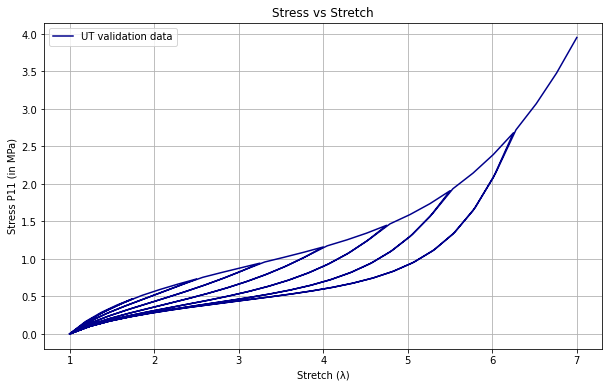

In [ ]:
# Importing the Validation data
UT_val  = pd.read_csv("CANN/Mooney_Rivlin_UT_Validate.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_val["Stretch"], UT_val["Stress_P11"], color='darkblue', label="UT validation data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch')
_ = plt.grid(visible=True)
_ = plt.legend()

In [ ]:
# Removing the duplicates in the data and getting the maximum stretches as the variable "max_stretch"
max_stretch_val, Stretch_val, Stress_val = remove_duplicates(UT_val)

# Deformation Gradient
F_val = deformation_grad(Stretch_val)

# Values at the Reference Configuration
F_val_ref, max_stretch_val_ref = reference_values(F_val, max_stretch_val)

In [ ]:
F_tr.shape, F_val.shape

(TensorShape([321, 3, 3]), TensorShape([200, 3, 3]))

In [ ]:
tf.random.set_seed(42)

# Instantiating the CANN model and plotting its graph
model = CANN()
model.summary()

# Instantiate an Optimizer
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-7, learning_rate=0.001)
# Instantiate a loss function
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss_fn)

Model: "cann__model_75"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 F (InputLayer)                 [(None, 3, 3)]       0           []                               
                                                                                                  
 right_cg_tensor_75 (right_CG_t  (None, 3, 3)        0           ['F[0][0]']                      
 ensor)                                                                                           
                                                                                                  
 first_invariant_75 (first_inva  (None, 1)           0           ['right_cg_tensor_75[0][0]']     
 riant)                                                                                           
                                                                                     

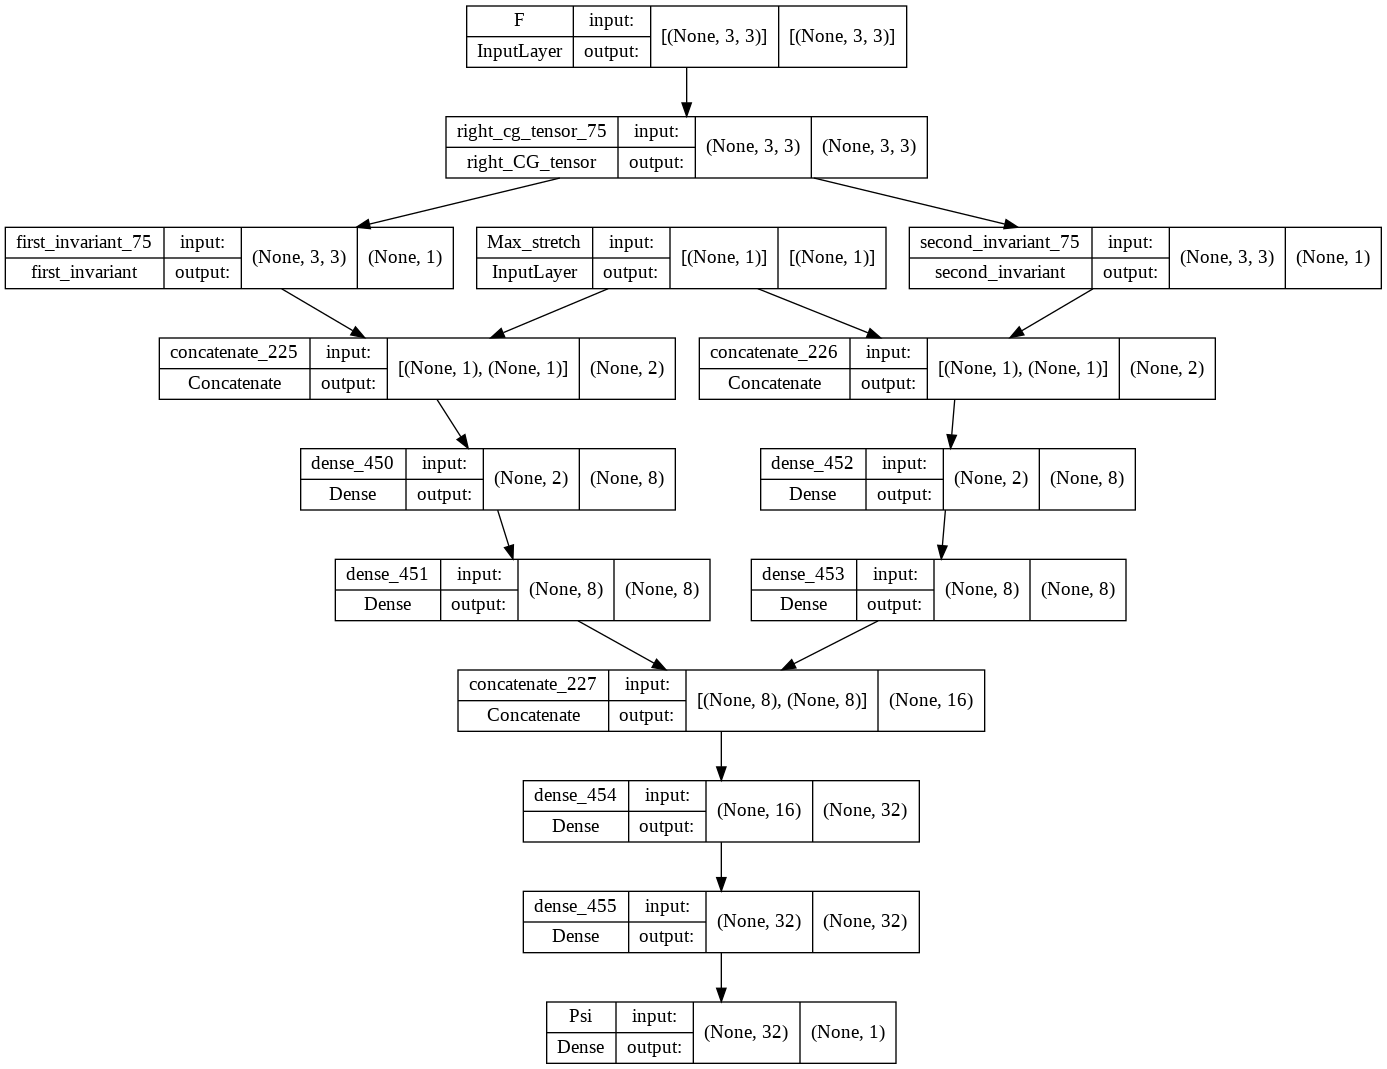

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Epoch 1/2000
11/11 [==============================] - 2s 70ms/step - loss: 0.7949 - val_loss: 0.4957
Epoch 2/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.2610 - val_loss: 0.1643
Epoch 3/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.1098 - val_loss: 0.1109
Epoch 4/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0975 - val_loss: 0.0940
Epoch 5/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.0784 - val_loss: 0.0882
Epoch 6/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0707 - val_loss: 0.0811
Epoch 7/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0665 - val_loss: 0.0748
Epoch 8/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0647 - val_loss: 0.0803
Epoch 9/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0629 - val_loss: 0.0721
Epoch 10/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0591 - val_loss: 0.063

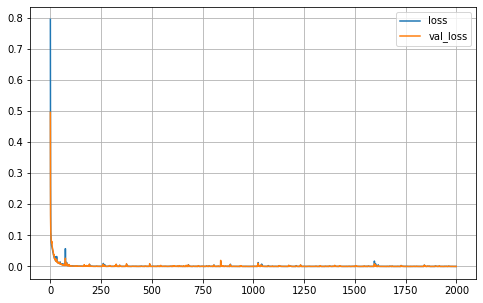

In [ ]:
#Fitting the UT data 
history = model.fit(((F_tr.numpy(), max_stretch_tr.numpy()), (F_tr_ref, max_stretch_tr_ref)), Stress_tr.numpy(), validation_data=(((F_val.numpy(), max_stretch_val.numpy()), (F_val_ref, max_stretch_val_ref)), Stress_val.numpy()), shuffle=True, epochs=2000, batch_size=32)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

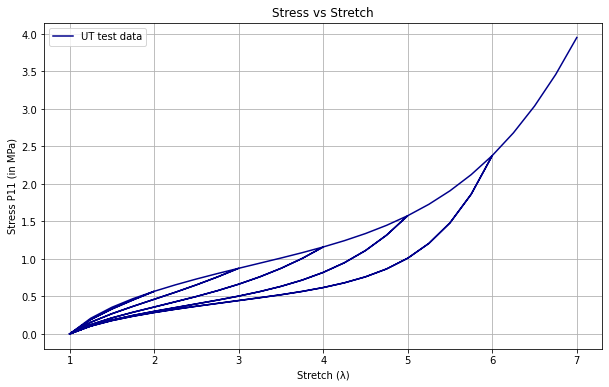

In [ ]:
# Importing the test data for UT
UT_te  = pd.read_csv("CANN/Mooney_Rivlin_UT_Test.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_te["Stretch"], UT_te["Stress_P11"], color='darkblue', label="UT test data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch')
_ = plt.grid(visible=True)
_ = plt.legend()

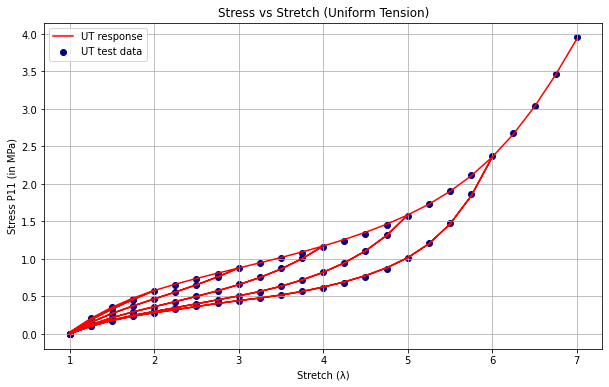

In [ ]:
# UT Response
Stretch_UT = tf.Variable(UT_te["Stretch"], dtype=tf.float32)
F_UT_te = deformation_grad(Stretch_UT, 0)
max_stretch_UT_te = maximum_stretch(Stretch_UT)
# Predicting the Stresses
Stress_UT_pred = Stress_predicted(model, F_UT_te, max_stretch_UT_te)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
max_stretch, Stretch_UT, Stress_P11_UT  = remove_duplicates(UT_te)
_ = plt.scatter(Stretch_UT, Stress_P11_UT, facecolors='darkblue', edgecolors='darkblue', marker='o', label="UT test data")
_ = plt.plot(UT_te["Stretch"], Stress_UT_pred, color='red', label="UT response")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Uniform Tension)')
_ = plt.grid(visible=True)
_ = plt.legend()

###**1.2 Stretched directly to λ = 10:**
The material is stretched directly to λ = 10, and the stretches are fed into the pre-trained model and the predicted stresses are compared to the actual stresses.

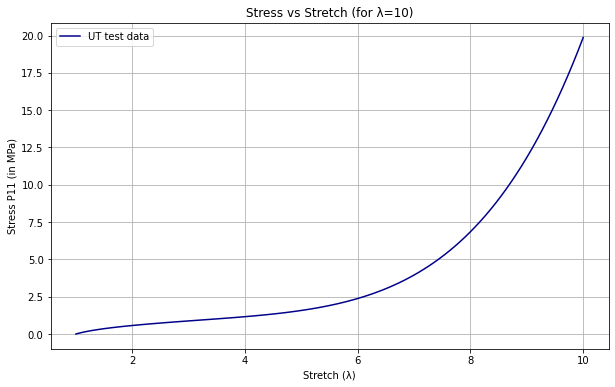

In [ ]:
# Importing the test data for UT
UT_10  = pd.read_csv("CANN/Mooney_Rivlin_Lambda_10.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_10["Stretch"], UT_10["Stress_P11"], color='darkblue', label="UT test data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (for λ=10)')
_ = plt.grid(visible=True)
_ = plt.legend()

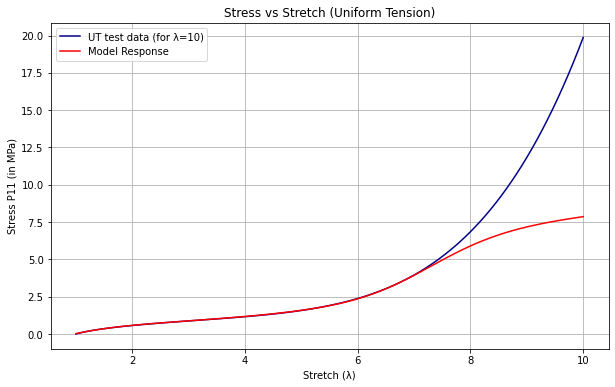

In [ ]:
# Model Prediction
Stretch_UT = tf.Variable(UT_10["Stretch"], dtype=tf.float32)
F_UT_te = deformation_grad(Stretch_UT, 0)
counter_UT_te = maximum_stretch(Stretch_UT)
# Predicting the Stresses
Stress_UT_pred = Stress_predicted(model, F_UT_te, counter_UT_te)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_10["Stretch"], UT_10["Stress_P11"], color='darkblue', label="UT test data (for λ=10)")
_ = plt.plot(UT_10["Stretch"], Stress_UT_pred, color='red', label="Model Response")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Uniform Tension)')
_ = plt.grid(visible=True)
_ = plt.legend()

##**2. UT, EBT and PS Loading Case:**
The material is loaded in Equi-Biaxial Tension and Pure shear as well as Uniaxial Tension, and the Stress vs Stretch data was used to check the predictions of the model. 

Three sets of data is used per loading type i.e for UT, EBT and PS each:

1. For Training: 1 - 1.5 - 1 - 2 - 1 - 2.5 - 1 - 3 - 1 -... - 7
2. For Validation: 1 - 1.75 - 1 - 2.5 - 1 - 3.25 - 1 -... - 7
3. For Testing: 1 - 2 - 1 - 3 - 1 -... - 7

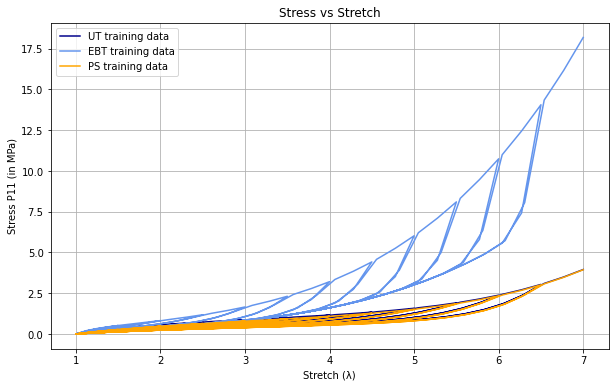

In [ ]:
# Importing the Training data
UT_train  = pd.read_csv("CANN/Mooney_Rivlin_UT_Train.csv")
EBT_train = pd.read_csv("CANN/Mooney_Rivlin_EBT_Train.csv")
PS_train  = pd.read_csv("CANN/Mooney_Rivlin_PS_Train.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_train["Stretch"], UT_train["Stress_P11"], color='darkblue', label="UT training data")
_ = plt.plot(EBT_train["Stretch"], EBT_train["Stress_P11"], color='cornflowerblue', label="EBT training data")
_ = plt.plot(PS_train["Stretch"], PS_train["Stress_P11"], color='orange', label="PS training data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch')
_ = plt.grid(visible=True)
_ = plt.legend()

In [ ]:
# Removing the duplicates in the data and getting the maximum stretches as the variable "max_stretch"
max_stretch_UT, Stretch_UT, Stress_UT = remove_duplicates(UT_train)
max_stretch_EBT, Stretch_EBT, Stress_EBT = remove_duplicates(EBT_train)
max_stretch_PS, Stretch_PS, Stress_PS = remove_duplicates(PS_train)

# Deformation Gradient
F_UT = deformation_grad(Stretch_UT)
F_EBT = deformation_grad(Stretch_EBT, 1)
F_PS = deformation_grad(Stretch_PS, 2)

# Combining the entire training set
F_tr = tf.concat([F_UT, F_EBT, F_PS], axis=0)
max_stretch_tr = tf.concat([max_stretch_UT, max_stretch_EBT, max_stretch_PS], axis=0)
Stress_tr = tf.concat([Stress_UT, Stress_EBT, Stress_PS], axis=0)

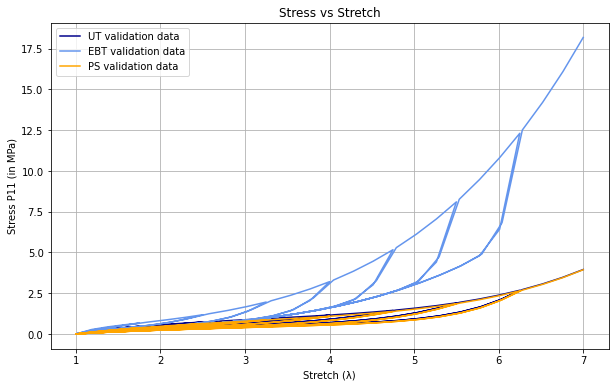

In [ ]:
# Importing the Validation data
UT_val  = pd.read_csv("CANN/Mooney_Rivlin_UT_Validate.csv")
EBT_val = pd.read_csv("CANN/Mooney_Rivlin_EBT_Validate.csv")
PS_val  = pd.read_csv("CANN/Mooney_Rivlin_PS_Validate.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_val["Stretch"], UT_val["Stress_P11"], color='darkblue', label="UT validation data")
_ = plt.plot(EBT_val["Stretch"], EBT_val["Stress_P11"], color='cornflowerblue', label="EBT validation data")
_ = plt.plot(PS_val["Stretch"], PS_val["Stress_P11"], color='orange', label="PS validation data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch')
_ = plt.grid(visible=True)
_ = plt.legend()

In [ ]:
# Removing the duplicates in the data and getting the maximum stretches as the variable "max_stretch"
max_stretch_UT, Stretch_UT, Stress_UT = remove_duplicates(UT_val)
max_stretch_EBT, Stretch_EBT, Stress_EBT = remove_duplicates(EBT_val)
max_stretch_PS, Stretch_PS, Stress_PS = remove_duplicates(PS_val)

# Deformation Gradient
F_UT = deformation_grad(Stretch_UT)
F_EBT = deformation_grad(Stretch_EBT, 1)
F_PS = deformation_grad(Stretch_PS, 2)

# Combining the entire training set
F_val = tf.concat([F_UT, F_EBT, F_PS], axis=0)
max_stretch_val = tf.concat([max_stretch_UT, max_stretch_EBT, max_stretch_PS], axis=0)
Stress_val = tf.concat([Stress_UT, Stress_EBT, Stress_PS], axis=0)

In [ ]:
# Setting the reference values for the training and validation sets. 
F_tr_ref, max_stretch_tr_ref = reference_values(F_tr, max_stretch_tr)
F_val_ref, max_stretch_val_ref = reference_values(F_val, max_stretch_val)

In [ ]:
F_tr.shape

TensorShape([963, 3, 3])

Streaming output truncated to the last 5000 lines.
31/31 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0134
Epoch 1502/4000
31/31 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0173
Epoch 1503/4000
31/31 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0116
Epoch 1504/4000
31/31 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0123
Epoch 1505/4000
31/31 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0305
Epoch 1506/4000
31/31 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0627
Epoch 1507/4000
31/31 [==============================] - 0s 4ms/step - loss: 0.0237 - val_loss: 0.0139
Epoch 1508/4000
31/31 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0213
Epoch 1509/4000
31/31 [==============================] - 0s 6ms/step - loss: 0.0171 - val_loss: 0.0321
Epoch 1510/4000
31/31 [===============

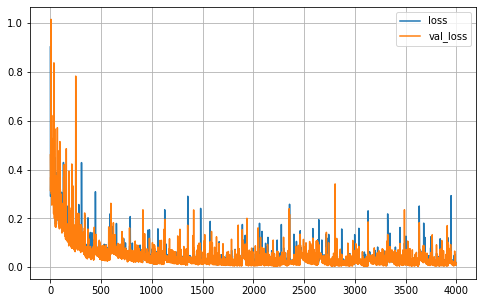

In [ ]:
tf.random.set_seed(42)

# Instantiating the CANN model
model = CANN()
model.summary()
# Instantiate an Optimizer
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-7, learning_rate=0.001)
# Instantiate a loss function
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss_fn)

#Fitting the UT data 
history = model.fit(((F_tr.numpy(), max_stretch_tr.numpy()), (F_tr_ref, max_stretch_tr_ref)), Stress_tr.numpy(), validation_data=(((F_val.numpy(), max_stretch_val.numpy()), (F_val_ref, max_stretch_val_ref)), Stress_val.numpy()), shuffle=True, epochs=4000, batch_size=32)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

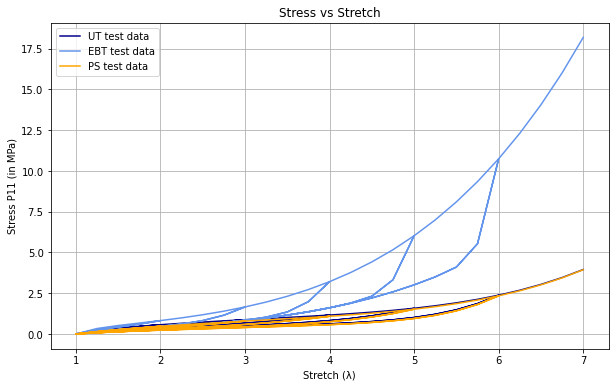

In [ ]:
# Importing the Test data
UT_te  = pd.read_csv("CANN/Mooney_Rivlin_UT_Test.csv")
EBT_te = pd.read_csv("CANN/Mooney_Rivlin_EBT_Test.csv")
PS_te  = pd.read_csv("CANN/Mooney_Rivlin_PS_Test.csv")

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_te["Stretch"], UT_te["Stress_P11"], color='darkblue', label="UT test data")
_ = plt.plot(EBT_te["Stretch"], EBT_te["Stress_P11"], color='cornflowerblue', label="EBT test data")
_ = plt.plot(PS_te["Stretch"], PS_te["Stress_P11"], color='orange', label="PS test data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch')
_ = plt.grid(visible=True)
_ = plt.legend()

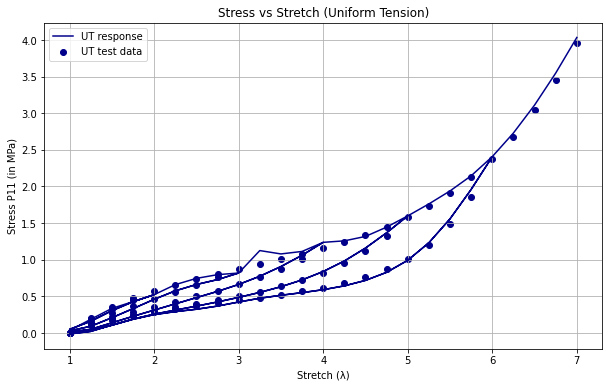

In [ ]:
# Prediction of Stresses / CANN Response and comparison to the actual Stress
# UT Response
Stretch_UT = tf.Variable(UT_te["Stretch"], dtype=tf.float32)
F_UT_te = deformation_grad(Stretch_UT, 0)
max_stretch_UT_te = maximum_stretch(Stretch_UT)
# Predicting the Stresses
Stress_UT_pred = Stress_predicted(model, F_UT_te, max_stretch_UT_te)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
max_stretch, Stretch_UT, Stress_P11_UT  = remove_duplicates(UT_te)
_ = plt.scatter(Stretch_UT, Stress_P11_UT, facecolors='darkblue', edgecolors='darkblue', marker='o', label="UT test data")
_ = plt.plot(UT_te["Stretch"], Stress_UT_pred, color='darkblue', label="UT response")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Uniform Tension)')
_ = plt.grid(visible=True)
_ = plt.legend()

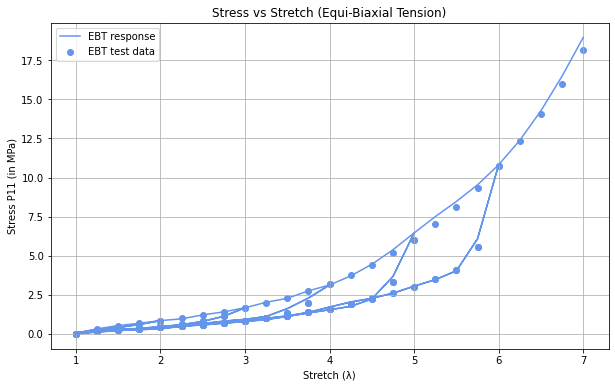

In [ ]:
# EBT Response
Stretch_EBT = tf.Variable(EBT_te["Stretch"], dtype=tf.float32)
F_EBT_te = deformation_grad(Stretch_EBT, 1)
max_stretch_EBT_te = maximum_stretch(Stretch_EBT)
# Predicting the Stresses
Stress_EBT_pred = Stress_predicted(model, F_EBT_te, max_stretch_EBT_te)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.scatter(EBT_te["Stretch"], EBT_te["Stress_P11"], facecolors='cornflowerblue', edgecolors='cornflowerblue', marker='o', label="EBT test data")
_ = plt.plot(EBT_te["Stretch"], Stress_EBT_pred, color='cornflowerblue', label="EBT response")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Equi-Biaxial Tension)')
_ = plt.grid(visible=True)
_ = plt.legend()

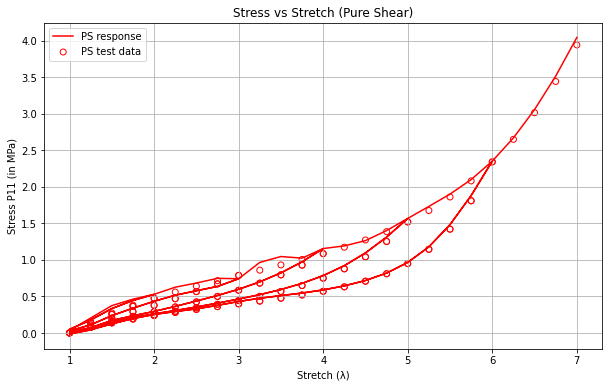

In [ ]:
# PS Response
Stretch_PS = tf.Variable(PS_te["Stretch"], dtype=tf.float32)
F_PS_te = deformation_grad(Stretch_PS, 2)
max_stretch_PS_te = maximum_stretch(Stretch_PS)
# Predicting the Stresses
Stress_PS_pred = Stress_predicted(model, F_PS_te, max_stretch_PS_te)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.scatter(PS_te["Stretch"], PS_te["Stress_P11"], facecolors='none', edgecolors='red', marker='o', label="PS test data")
_ = plt.plot(PS_te["Stretch"], Stress_PS_pred, color='red', label="PS response")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Pure Shear)')
_ = plt.grid(visible=True)
_ = plt.legend()

##**3. Using Noisy Data:**
The model is trained and validated using the Uniaxial Tension data used in **'1.'**, adding Gaussian Noise of mean 0 and standard deviation of 5% to the Stress labels of the data.

Then its performance is evaluated against the test data without noise.

In [ ]:
# Function for creating and adding noise
def create_noise(input):
  """
  Adds Gaussian Noise to the input data with mean 0 and standard deviation 5%.

  Parameters:
      input        : input Stress data without noise
  
  Returns:
      noisy_input  : Stress data with noise added to it
      
  """
  noise = tf.random.normal(input.shape, mean=0, stddev=0.05, dtype=tf.float32, seed=42)
  noisy_input = tf.add(input, noise)

  return noisy_input

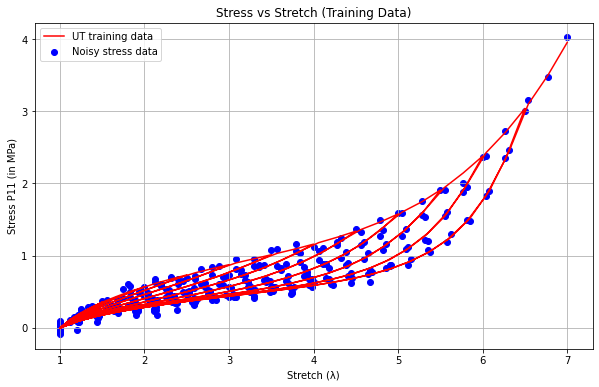

In [ ]:
# Importing the Training data
UT_train  = pd.read_csv("CANN/Mooney_Rivlin_UT_Train.csv")
max_stretch_tr, Stretch_tr, Stress_tr = remove_duplicates(UT_train)
Stress_noisy_tr = create_noise(Stress_tr)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_train["Stretch"], UT_train["Stress_P11"], color='red', label="UT training data")
_ = plt.scatter(Stretch_tr.numpy(), Stress_noisy_tr.numpy(), facecolors='blue', edgecolors='blue', label="Noisy stress data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Training Data)')
_ = plt.grid(visible=True)
_ = plt.legend()

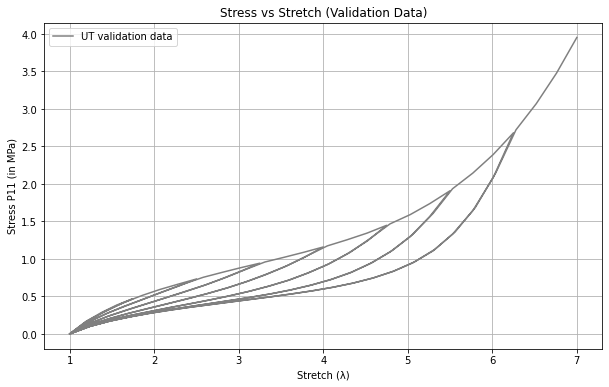

In [ ]:
# Importing the Validation data
UT_val  = pd.read_csv("CANN/Mooney_Rivlin_UT_Validate.csv")
max_stretch_val, Stretch_val, Stress_val = remove_duplicates(UT_val)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
_ = plt.plot(UT_val["Stretch"], UT_val["Stress_P11"], color='gray', label="UT validation data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Validation Data)')
_ = plt.grid(visible=True)
_ = plt.legend()

In [ ]:
# Deformation Gradients
F_tr = deformation_grad(Stretch_tr)
F_val = deformation_grad(Stretch_val)

# Values at the reference configuration
F_tr_ref, max_stretch_tr_ref = reference_values(F_tr, max_stretch_tr)
F_val_ref, max_stretch_val_ref = reference_values(F_val, max_stretch_val)

In [ ]:
tf.random.set_seed(42)

# Instantiating the CANN model
model_noise = CANN()
model_noise.summary()

# Instantiate an Optimizer
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-7, learning_rate=0.001)
# Instantiate a loss function
loss_fn = keras.losses.MeanSquaredError()
model_noise.compile(optimizer=optimizer, loss=loss_fn)

Model: "cann__model_77"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 F (InputLayer)                 [(None, 3, 3)]       0           []                               
                                                                                                  
 right_cg_tensor_77 (right_CG_t  (None, 3, 3)        0           ['F[0][0]']                      
 ensor)                                                                                           
                                                                                                  
 first_invariant_77 (first_inva  (None, 1)           0           ['right_cg_tensor_77[0][0]']     
 riant)                                                                                           
                                                                                     

Epoch 1/2000
11/11 [==============================] - 2s 71ms/step - loss: 0.7863 - val_loss: 0.4964
Epoch 2/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.2575 - val_loss: 0.1627
Epoch 3/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.1110 - val_loss: 0.1100
Epoch 4/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.1014 - val_loss: 0.0930
Epoch 5/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.0818 - val_loss: 0.0905
Epoch 6/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0741 - val_loss: 0.0818
Epoch 7/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0697 - val_loss: 0.0744
Epoch 8/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.0673 - val_loss: 0.0816
Epoch 9/2000
11/11 [==============================] - 0s 5ms/step - loss: 0.0656 - val_loss: 0.0726
Epoch 10/2000
11/11 [==============================] - 0s 7ms/step - loss: 0.0619 - val_loss: 0.063

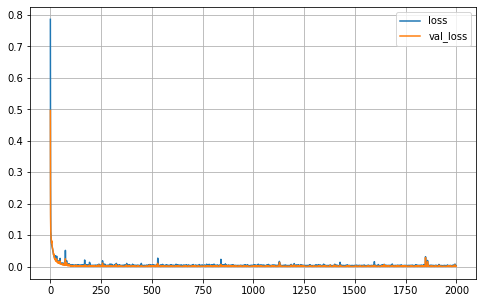

In [ ]:
#Fitting the noisy data 
history = model_noise.fit(((F_tr.numpy(), max_stretch_tr.numpy()), (F_tr_ref, max_stretch_tr_ref)), Stress_noisy_tr.numpy(), validation_data=(((F_val.numpy(), max_stretch_val.numpy()), (F_val_ref, max_stretch_val_ref)), Stress_val.numpy()), shuffle=True, epochs=2000, batch_size=32)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

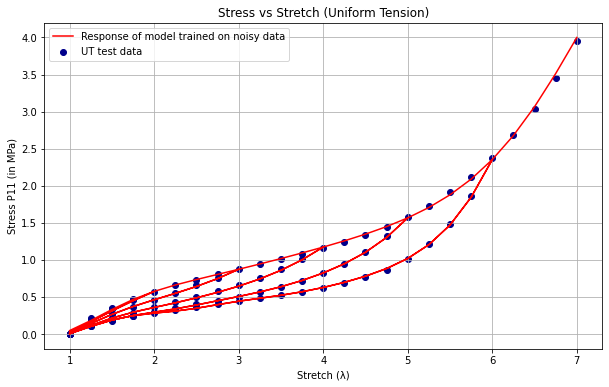

In [ ]:
# Importing the test data for UT
UT_te  = pd.read_csv("CANN/Mooney_Rivlin_UT_Test.csv")

# UT Response of the CANN trained on noisy data
Stretch_UT = tf.Variable(UT_te["Stretch"], dtype=tf.float32)
F_UT_te = deformation_grad(Stretch_UT, 0)
max_stretch_UT_te = maximum_stretch(Stretch_UT)
# Predicting the Stresses
Stress_UT_pred = Stress_predicted(model_noise, F_UT_te, max_stretch_UT_te)

# Plotting the Stretch vs Stress
mpl.rcParams['figure.figsize'] = (10, 6)
max_stretch, Stretch_UT, Stress_P11_UT  = remove_duplicates(UT_te)
_ = plt.scatter(Stretch_UT, Stress_P11_UT, facecolors='darkblue', edgecolors='darkblue', marker='o', label="UT test data")
_ = plt.plot(UT_te["Stretch"], Stress_UT_pred, color='red', label="Response of model trained on noisy data")
plt.xlabel('Stretch (λ)')
plt.ylabel('Stress P11 (in MPa)')
_ = plt.title('Stress vs Stretch (Uniform Tension)')
_ = plt.grid(visible=True)
_ = plt.legend()

## **4. Predictive quality over number of points used for Training:**

The number of data points used for training in the previous examples for Uniaxial Tension is 293. The change of the quality of the prediction as compared to the number of training data points can be a good factor to investigate.

The validation data will be the same as used before with 109 data points and the testing data will also be the same with 134 data points. The confidence interval used is 80%.

In [ ]:
# Importing all the data into a common dataframe
import glob

path       = 'CANN/Relative_Error_Files/'
csv_files  = glob.glob(path + "*.csv")

csv_files.sort()
print(csv_files)

['CANN/Relative_Error_Files/0.csv', 'CANN/Relative_Error_Files/1.csv', 'CANN/Relative_Error_Files/2.csv', 'CANN/Relative_Error_Files/3.csv', 'CANN/Relative_Error_Files/4.csv', 'CANN/Relative_Error_Files/5.csv', 'CANN/Relative_Error_Files/6.csv', 'CANN/Relative_Error_Files/7.csv', 'CANN/Relative_Error_Files/8.csv', 'CANN/Relative_Error_Files/9.csv']


In [ ]:
# Preparing an empty list to be filled with the relative error data
df = [] #["Training_Data_Points", "Mean", "Standard_Deviation", "CI_pos", "CI_neg"]

for i in range(len(csv_files)):

  UT_train  = pd.read_csv(csv_files[i])

  # Removing the duplicates in the data and getting the maximum stretches as the variable "max_stretch"
  max_stretch_tr, Stretch_tr, Stress_tr = remove_duplicates(UT_train)

  # Deformation Gradient
  F_tr = deformation_grad(Stretch_tr)

  # Values at the Reference Configuration
  F_tr_ref, max_stretch_tr_ref = reference_values(F_tr, max_stretch_tr)

  # Importing the Validation data
  UT_val  = pd.read_csv("CANN/Mooney_Rivlin_UT_Validate.csv")

  # Removing the duplicates in the data and getting the maximum stretches as the variable "max_stretch"
  max_stretch_val, Stretch_val, Stress_val = remove_duplicates(UT_val)

  # Deformation Gradient
  F_val = deformation_grad(Stretch_val)

  # Values at the Reference Configuration
  F_val_ref, max_stretch_val_ref = reference_values(F_val, max_stretch_val)

  # Number of Training Datapoints
  data_points = F_tr.shape[0]
  print("\n The number of training data points is: ", data_points)

  mean_rel_error = []
  tf.random.set_seed(42)

  for j in range(15): # Running the model 15 times per dataset and getting the mean and std. dev of the error

    # Instantiating the CANN model
    
    model = CANN()

    # Instantiate an Optimizer
    optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-7, learning_rate=0.001)
    # Instantiate a loss function
    loss_fn = keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss_fn)

    #Fitting the UT data 
    history = model.fit(((F_tr.numpy(), max_stretch_tr.numpy()), (F_tr_ref, max_stretch_tr_ref)), Stress_tr.numpy(), validation_data=(((F_val.numpy(), max_stretch_val.numpy()), (F_val_ref, max_stretch_val_ref)), Stress_val.numpy()), verbose=0, shuffle=True, epochs=1000, batch_size=32)

    # Importing the test data for UT
    UT_te  = pd.read_csv("CANN/Mooney_Rivlin_UT_Test.csv")
    Stretch_UT = tf.Variable(UT_te["Stretch"], dtype=tf.float32)
    F_UT_te = deformation_grad(Stretch_UT, 0)
    max_stretch_UT_te = maximum_stretch(Stretch_UT)
    Stress_UT_te = tf.Variable(UT_te["Stress_P11"], dtype=tf.float32)
    # Predicting the Stresses
    Stress_UT_pred = Stress_predicted(model, F_UT_te, max_stretch_UT_te)

    # Removing the Stresses that are 0 in value
    zero_places = np.where(Stress_UT_te == 0.0)
    Stress_UT_te = np.delete(Stress_UT_te, zero_places)
    Stress_UT_pred = np.delete(Stress_UT_pred, zero_places)

    # Relative error percentage in the predictions
    rel_error = tf.Variable(0, dtype=tf.float32)

    for k in range(Stress_UT_te.shape[0]):
      rel_error = tf.add(rel_error, (tf.abs(Stress_UT_pred[k] - Stress_UT_te[k]))/(Stress_UT_te[k]))

    mr = rel_error*100/Stress_UT_te.shape[0]
    print("Relative error for run:", j+1, " of Set: ",i," is: ", mr.numpy())
    mean_rel_error.append([mr.numpy()])

  mean_rel_error = np.asarray(mean_rel_error)
  mean    = np.mean(mean_rel_error)
  std_dev = np.std(mean_rel_error)
  CI_pos = mean + 1.282*(std_dev/np.sqrt(15))
  CI_neg = mean - 1.282*(std_dev/np.sqrt(15))
  df.append([data_points, mean, std_dev, CI_pos, CI_neg])


 The number of training data points is:  79
Relative error for run: 1  of Set:  0  is:  3.5453258
Relative error for run: 2  of Set:  0  is:  1.9637594
Relative error for run: 3  of Set:  0  is:  4.1580086
Relative error for run: 4  of Set:  0  is:  2.833196
Relative error for run: 5  of Set:  0  is:  2.7148185
Relative error for run: 6  of Set:  0  is:  4.812307
Relative error for run: 7  of Set:  0  is:  3.034481
Relative error for run: 8  of Set:  0  is:  4.425859
Relative error for run: 9  of Set:  0  is:  2.604593
Relative error for run: 10  of Set:  0  is:  3.6402123
Relative error for run: 11  of Set:  0  is:  5.317926
Relative error for run: 12  of Set:  0  is:  3.2517707
Relative error for run: 13  of Set:  0  is:  4.0977635
Relative error for run: 14  of Set:  0  is:  7.571503
Relative error for run: 15  of Set:  0  is:  6.5035973

 The number of training data points is:  163
Relative error for run: 1  of Set:  1  is:  6.17354
Relative error for run: 2  of Set:  1  is:  1.85

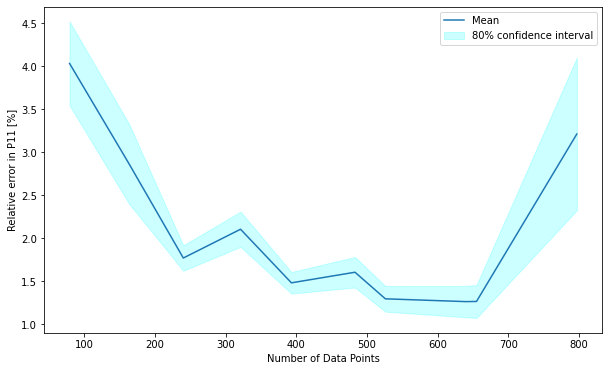

In [ ]:
# Converting the list into a Dataframe
rel_error = pd.DataFrame(df, columns=["Training_Data_Points", "Mean", "Standard_Deviation", "CI_pos", "CI_neg"])

# Plotting the mean and conidence interval for the datapoints
fig, ax = plt.subplots()
ax.plot(rel_error["Training_Data_Points"], rel_error["Mean"], label="Mean")
ax.fill_between(rel_error["Training_Data_Points"], rel_error["CI_neg"], rel_error["CI_pos"], color='cyan', alpha=.2, label="80% confidence interval")
_ = plt.xlabel("Number of Data Points")
_ = plt.ylabel("Relative error in P11 [%]")
_ = plt.legend()